# Dimensionality Reduction: Pitfalls

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume.pylab as p3
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from IPython.display import YouTubeVideo

In [2]:
pca = PCA()

mpl.rcParams.update({'font.size':16})

# A function for plotting 3-dimensional data
def plot3d(df):
    data = df.values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*data[:,0:3].T)
    minn,maxx = data.min(),data.max()
    ax.set_xlim(minn,maxx)
    ax.set_ylim(minn,maxx)
    ax.set_zlim(minn,maxx)
    ax.set_xlabel(df.columns[0],labelpad=10)
    ax.set_ylabel(df.columns[1],labelpad=10)
    ax.set_zlabel(df.columns[2],labelpad=10)
    ax.dist = 12
    plt.tight_layout()
    
def plot3d_live(data):
    fig = p3.figure()
    q = p3.scatter(*data.T, size=1, marker="sphere")
    p3.style.use("dark") # looks better
    p3.show()
        
# A function for summarizing covariancs and correlations
def summarize(info,name,quiet=False):
    values = info[name]
    if not quiet:
        print(values.round(2))
    plt.pcolor(values,cmap='RdBu_r',vmin=-values.max(),vmax=values.max())
    raynge = np.arange(values.shape[0])
    if not quiet:
        plt.xticks(raynge+0.5,raynge)
        plt.yticks(raynge+0.5,raynge)
    else:
        plt.xticks([])
        plt.yticks([])
    plt.gca().invert_yaxis() # Make y-axis go from low to high like a matrix
    plt.colorbar().set_label(name)
    if not quiet:
        eigenvalues,_ = np.linalg.eig(info[name])
        for i,eig in enumerate(sorted(eigenvalues,reverse=True)):
            print('Eigenvalue #%d is %.3g' % (i+1,eig))
        
def report_mean_var(data):
    for i in range(data.shape[1]):
        column = data[:,i]
        print("Dimension %d has mean %.2g and variance %.3g" % \
              (i+1,column.mean(),column.var()))
        
def annotate_scatter(ax,df):
    for i, text in enumerate(df.index):
        ax.text(df['PC 1'].iloc[i],df['PC 2'].iloc[i], text)
        
def variance_explained(df,pca):
    pca.fit(df.values)
    for i in range(min(*df.shape)):
        print("PC %d explains %.3g%% of the variance" % (i+1,100*pca.explained_variance_ratio_[i]))
        
def pc_report(pca,df):
    pca.fit(df.values)
    pca_df = pd.DataFrame(pca.components_.T,
                          index=df.columns,
                          columns=['PC %d' % (i+1) for i in range(min(*df.shape))])
    pca_df = pca_df.applymap(lambda x:'%.3g' % x)
    return pca_df

def plot_transformed_data(pca,df,figsize=None):
    pca.fit(df.values)
    pca_df = pd.DataFrame(pca.transform(df.values),
                      index=df.index,
                      columns=['PC %d' % (i+1) for i in range(min(*df.shape))])
    ax = pca_df.plot.scatter('PC 1','PC 2',figsize=figsize)
    annotate_scatter(ax,pca_df)

my_fake_data = np.random.rand(100,3)
my_fake_data[:,2] = (my_fake_data[:,0] + my_fake_data[:,1])/np.sqrt(2)

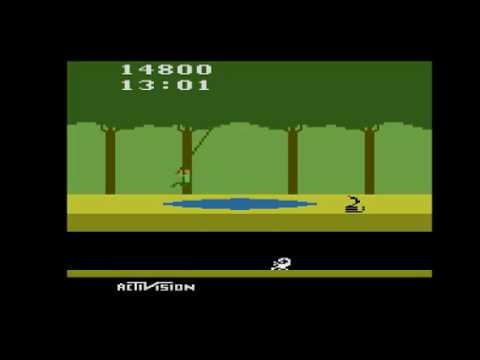

In [3]:
YouTubeVideo('MhXMYw1lXY0')

## Pitfall #1: Data has no structure to extract

In [4]:
df = pd.DataFrame(np.random.randn(500,3)) # Random data
plot3d_live(df.values) # Won't look interesting no matter what axes you use!

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white', dtype='<U5'), geo='sphere', size=array(1), size_selected=array(2.6), x=array([-1.07363808e+00, -2.64306366e-01, -7.22496576e-01,  9.41708967e-01,
       -6.13038444e-01,  2.75353409e-02,  6.09993903e-02, -7.70355306e-01,
        1.54062481e-01, -1.93204291e-01, -9.15219713e-01,  3.93840066e-01,
        2.92091714e-01, -9.02354516e-01, -4.31476678e-01, -9.25106494e-02,
        1.93181390e-01, -1.02012823e+00,  2.40013501e-01, -3.20224967e-01,
       -1.65557713e+00,  4.60472961e-01, -1.00819939e+00, -1.42207976e-01,
       -1.14492489e+00,  2.77507368e-01, -2.42840602e-01,  1.31757724e+00,
       -3.00301952e-01,  1.01562594e+00, -1.41696837e+00,  1.43155950e-01,
       -1.57638466e+00,  7.93401316e-01,  7.28110854e-01,  1.51469325e+00,
       -1.45085490e+00,  9.65997688e-01, -2.45434893e-01, -1.60650529e-01,
       -1.25737583e-01,  5.74173621e-01,  1.06258063e+00, -9.83005807e-01,
        7.10229384e-01,  2.59034377e+00,  9.76530445e-02, -1.27304422e-01,
        4.49263348e-01, -8.42217905e-01,  2.84761689e+00,  7.07822606e-01,
       -3.95266101e-02, -2.08075768e-01,  2.08068266e+00,  3.98466871e-01,
        5.43730114e-01, -1.02532242e+00, -9.63459762e-01, -1.76321089e+00,
       -9.61267400e-01,  5.89993899e-01, -6.69576530e-01,  1.49401010e-01,
       -2.71013688e-02,  1.85951921e-01, -8.43672198e-01,  6.55926783e-01,
        3.55129087e-02, -1.77425931e+00,  2.94184932e-01,  3.24908469e-01,
       -1.82584083e+00, -6.40688973e-01,  1.76552432e-01, -1.24024155e+00,
       -5.15104107e-01, -2.21350570e-02,  6.00420386e-01, -7.30924515e-01,
        6.28580401e-01,  8.22462698e-01,  1.34126910e+00,  1.29632620e+00,
        4.57223347e-01,  1.58384993e-01, -6.63001072e-01,  1.88488029e+00,
       -1.21991468e+00, -1.12188177e-01, -6.10285606e-01, -1.17845060e-01,
        9.87826697e-01, -5.22309916e-01,  2.72685247e-02,  1.23449656e+00,
        4.88518046e-01,  3.95992875e-01,  1.69912607e+00, -2.32516850e+00,
        3.62049554e-01,  1.33940385e-01, -8.26498157e-01,  8.29758716e-02,
        3.63217787e-01, -1.37812427e-01,  3.33151241e-01,  1.20645356e+00,
        2.37708774e+00,  9.81572613e-02, -4.77574045e-01, -1.25800972e+00,
        5.57594147e-01, -6.50805637e-01,  1.12250482e+00, -9.77047726e-01,
       -2.14081544e-01, -1.05245475e+00,  7.21030422e-01,  1.48713650e+00,
       -4.56649841e-02,  1.09684799e+00,  1.27870746e+00,  1.72618477e-02,
        1.75969165e+00,  1.91115463e-01,  1.83896316e+00,  2.34290328e+00,
       -3.09453443e-01,  1.96893009e+00,  8.33235622e-02, -5.46031819e-01,
       -7.66476607e-01,  2.40677706e-01, -1.79289555e-01, -4.31839377e-01,
       -4.99009571e-01,  7.52314805e-01,  7.34685941e-01, -6.38982606e-01,
       -1.01417891e+00, -4.75499551e-01, -1.16135654e+00,  1.88519659e-01,
       -4.89109514e-01,  9.12376265e-01, -1.63953043e+00, -5.84659777e-02,
        9.13520018e-01,  1.32281306e+00, -1.42605985e+00,  9.24672558e-01,
       -2.20769167e+00, -5.80544698e-01,  8.48243141e-01, -7.64153529e-01,
       -1.65306561e+00,  1.15159592e+00,  2.67445823e-01,  1.32353637e+00,
        1.49082638e+00, -1.00718073e+00,  1.27711028e-01, -1.69511444e+00,
       -3.80503923e-01, -6.39272739e-02,  1.30541696e+00,  1.45978355e-01,
        1.94078560e-01,  5.79357561e-01,  9.14018534e-02,  7.08041750e-01,
       -3.86117059e-01, -2.24055017e+00, -9.58747833e-01, -1.47527462e+00,
        2.63859868e-01, -4.96335661e-01,  1.45604917e+00, -1.93713741e+00,
        2.13437452e-01, -1.27827139e+00, -2.01052126e-01, -9.05673830e-01,
        5.41796907e-01, -1.61432459e+00,  8.02393689e-01, -3.06792315e-01,
       -9.90565398e-02,  1.51250240e-01, -5.69923746e-01, -7.54627859e-01,
       -2.03161166e+0

In [5]:
pca.fit(df.values)
variance_explained(df,pca)

PC 1 explains 37% of the variance
PC 2 explains 32.8% of the variance
PC 3 explains 30.1% of the variance


## Potential solution: Use more interesting data

## Pitfall #2: Dimensions have *very* unequal variances

In [6]:
df = pd.read_csv('data/crimedata.csv',delimiter='\t',thousands=',')

In [7]:
df = df.rename(columns=lambda x:x.replace('\n',' ').replace('  ',' '))
df = df.replace(20013,2001)
df = df.replace(20124,2012)

In [8]:
df.head()

,Year,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
0,1994,260327021,1857670,713.6,23326,9.0
1,1995,262803276,1798792,684.5,21606,8.2
2,1996,265228572,1688540,636.6,19645,7.4
3,1997,267783607,1636096,611.0,18208,6.8
4,1998,270248003,1533887,567.6,16974,6.3


In [9]:
df.var()

Year                                          3.500000e+01
Population1                                   3.355489e+14
Violent crime                                 3.457880e+10
Violent crime rate                            9.376104e+03
Murder and nonnegligent manslaughter          5.374923e+06
Murder and nonnegligent manslaughter rate     1.365132e+00
dtype: float64

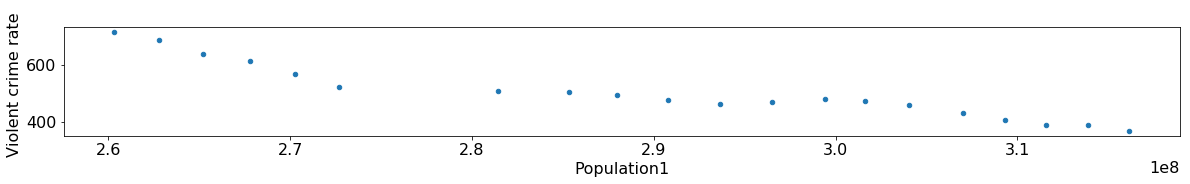

In [10]:
df.plot.scatter('Population1','Violent crime rate ',figsize=(20,2));

In [11]:
pca.fit(df.values)
variance_explained(df,pca)

PC 1 explains 100% of the variance
PC 2 explains 0.00178% of the variance
PC 3 explains 6.28e-08% of the variance
PC 4 explains 5.78e-12% of the variance
PC 5 explains 5.02e-14% of the variance
PC 6 explains 1.96e-16% of the variance


## Potential solution: normalize the data so that each column has the same variance

In [12]:
def normalize(df):
    df_norm = df.div(df.std()) # Divide each column by its standard deviation
    df_norm = df_norm.sub(df_norm.mean()) # Optionally subtract the mean from each column
    df_norm = df_norm.rename(columns = lambda x:x+' normalized') # Add "normalized' to column names
    return df_norm

df_norm = normalize(df)
df_norm.var()

Year normalized                                          1.0
Population1 normalized                                   1.0
Violent crime normalized                                 1.0
Violent crime rate  normalized                           1.0
Murder and nonnegligent manslaughter normalized          1.0
Murder and nonnegligent manslaughter rate  normalized    1.0
dtype: float64

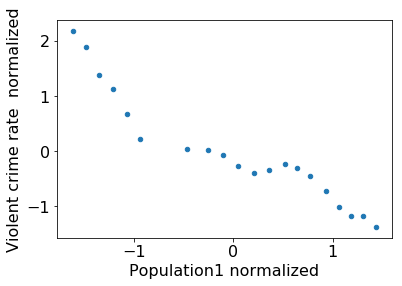

In [13]:
df_norm.plot.scatter('Population1 normalized','Violent crime rate  normalized');

In [14]:
pca.fit(df_norm.values)
variance_explained(df_norm,pca)

PC 1 explains 93.2% of the variance
PC 2 explains 6.36% of the variance
PC 3 explains 0.258% of the variance
PC 4 explains 0.178% of the variance
PC 5 explains 0.0106% of the variance
PC 6 explains 0.00241% of the variance


In [15]:
pc_report(pca,df_norm)

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6
Year normalized,-0.4,-0.514,0.149,0.677,-0.305,0.047
Population1 normalized,-0.4,-0.514,0.239,-0.409,0.586,-0.0915
Violent crime normalized,0.42,-0.135,0.754,-0.12,-0.153,0.446
Violent crime rate normalized,0.422,0.0245,0.293,0.42,0.383,-0.642
Murder and nonnegligent manslaughter normalized,0.393,-0.593,-0.254,-0.333,-0.436,-0.359
Murder and nonnegligent manslaughter rate normalized,0.414,-0.319,-0.449,0.269,0.451,0.5


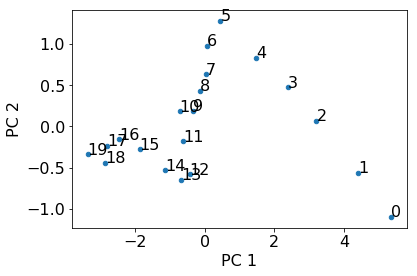

In [16]:
plot_transformed_data(pca,df_norm)

## Pitfall #3: Treating independent variables as measurements of interest

In [17]:
df.head()

,Year,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
0,1994,260327021,1857670,713.6,23326,9.0
1,1995,262803276,1798792,684.5,21606,8.2
2,1996,265228572,1688540,636.6,19645,7.4
3,1997,267783607,1636096,611.0,18208,6.8
4,1998,270248003,1533887,567.6,16974,6.3


## Potential solution: Move independent variables to the index

In [18]:
df = df.set_index('Year')
df.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1994,260327021,1857670,713.6,23326,9.0
1995,262803276,1798792,684.5,21606,8.2
1996,265228572,1688540,636.6,19645,7.4
1997,267783607,1636096,611.0,18208,6.8
1998,270248003,1533887,567.6,16974,6.3


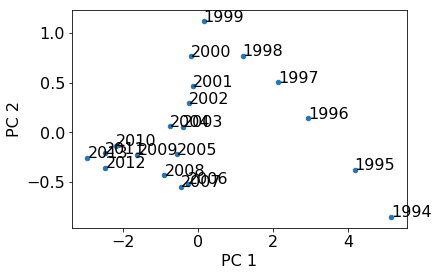

In [19]:
df_norm = normalize(df)
plot_transformed_data(pca,df_norm)

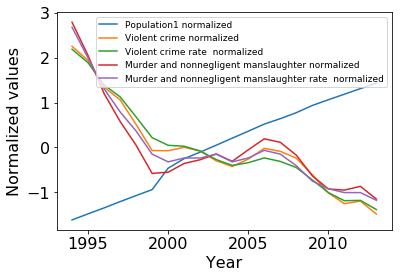

In [20]:
df_norm.plot.line()
plt.legend(fontsize=9)
plt.ylabel('Normalized values');

## Pitfall #4: Observations are highly correlated

In [21]:
df.corr().round(2)

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Population1,1.00,-0.91,-0.95,-0.76,-0.87
Violent crime,-0.91,1.00,0.99,0.95,0.98
Violent crime rate,-0.95,0.99,1.00,0.92,0.97
Murder and nonnegligent manslaughter,-0.76,0.95,0.92,1.00,0.98
Murder and nonnegligent manslaughter rate,-0.87,0.98,0.97,0.98,1.00


## Potential solution: Use changes in values instead of the original values

In [22]:
df_diff = df.diff().dropna()
df_diff.head()

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Year,,,,,
1995,2476255.0,-58878.0,-29.1,-1720.0,-0.8
1996,2425296.0,-110252.0,-47.9,-1961.0,-0.8
1997,2555035.0,-52444.0,-25.6,-1437.0,-0.6
1998,2464396.0,-102209.0,-43.4,-1234.0,-0.5
1999,2442810.0,-107843.0,-44.6,-1452.0,-0.6


In [23]:
df_diff.corr().round(2)

,Population1,Violent crime,Violent crime rate,Murder and nonnegligent manslaughter,Murder and nonnegligent manslaughter rate
Population1,1.00,0.29,0.12,0.26,0.13
Violent crime,0.29,1.00,0.98,0.86,0.80
Violent crime rate,0.12,0.98,1.00,0.88,0.85
Murder and nonnegligent manslaughter,0.26,0.86,0.88,1.00,0.98
Murder and nonnegligent manslaughter rate,0.13,0.80,0.85,0.98,1.00


In [24]:
df_diff = normalize(df_diff)
variance_explained(df_diff,pca)

PC 1 explains 74.7% of the variance
PC 2 explains 19.4% of the variance
PC 3 explains 5.66% of the variance
PC 4 explains 0.235% of the variance
PC 5 explains 0.0676% of the variance


In [25]:
pc_report(pca,df_diff)

,PC 1,PC 2,PC 3,PC 4,PC 5
Population1 normalized,-0.145,0.975,-0.0494,0.149,0.0589
Violent crime normalized,-0.494,0.0374,0.548,-0.308,-0.6
Violent crime rate normalized,-0.496,-0.152,0.448,0.431,0.587
Murder and nonnegligent manslaughter normalized,-0.503,-0.0178,-0.416,-0.66,0.373
Murder and nonnegligent manslaughter rate normalized,-0.486,-0.156,-0.569,0.512,-0.392


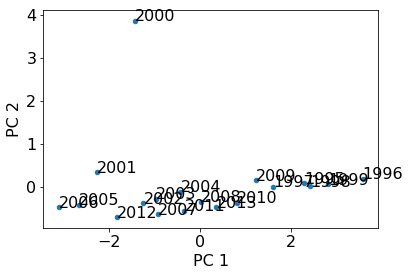

In [26]:
plot_transformed_data(pca,df_diff)

## Pitfall #5: Including other non-measurments in the "data"

In [27]:
df = pd.read_csv('data/2017shooting.csv')
df.head()

,RK,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,PPS,AFG%
0,1,114.4,39.4,85.6,0.460,15.7,43.2,0.364,19.9,25.2,0.792,1.34,0.552
1,2,105.7,37.8,86.7,0.436,11.9,34.0,0.348,18.2,23.9,0.761,1.22,0.504
2,3,109.7,39.6,83.9,0.472,12.0,32.8,0.365,18.6,23.2,0.801,1.31,0.543
3,4,102.5,38.1,84.5,0.451,11.6,31.9,0.365,14.7,19.0,0.774,1.21,0.520
4,5,111.3,40.9,87.4,0.468,11.2,31.8,0.351,18.4,22.9,0.804,1.27,0.532


## Potential solution: Get rid of those non-measurements

In [28]:
df = df.drop('RK',axis=1)
df.head()

,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,PPS,AFG%
0,114.4,39.4,85.6,0.460,15.7,43.2,0.364,19.9,25.2,0.792,1.34,0.552
1,105.7,37.8,86.7,0.436,11.9,34.0,0.348,18.2,23.9,0.761,1.22,0.504
2,109.7,39.6,83.9,0.472,12.0,32.8,0.365,18.6,23.2,0.801,1.31,0.543
3,102.5,38.1,84.5,0.451,11.6,31.9,0.365,14.7,19.0,0.774,1.21,0.520
4,111.3,40.9,87.4,0.468,11.2,31.8,0.351,18.4,22.9,0.804,1.27,0.532


## Pitfall #6: Unlabeled data

## Potential solution: Labeled data

In [29]:
df = pd.read_csv('data/basketball.csv')
df['Player'] = df['Player'].map(lambda x:x.split('\\')[0])
df = df.drop(['Player','Rk','Tm','Age'],axis=1).set_index(['Pos']).fillna(0)
df.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
Pos,,,,,,,,,,,,,,,,,,,,,
SG,56,8,16.0,1.6,4.1,0.384,1.1,3.0,0.367,0.5,...,0.872,0.4,1.3,1.7,0.4,0.5,0.1,0.4,1.7,4.9
PF,54,8,20.7,1.8,5.3,0.336,1.4,4.2,0.329,0.4,...,0.821,0.7,3.5,4.1,0.8,0.5,0.4,1.0,2.1,5.8
C,57,57,32.6,6.0,9.5,0.631,0.0,0.0,0.000,6.0,...,0.571,5.1,3.9,9.1,1.0,1.2,1.1,1.5,2.9,14.0
C,51,11,20.5,2.7,4.8,0.551,0.0,0.1,0.000,2.7,...,0.732,1.6,3.8,5.4,1.6,0.5,0.6,0.9,2.1,7.4
SG,45,2,12.8,1.2,3.0,0.388,0.5,1.3,0.386,0.7,...,0.833,0.1,1.3,1.4,0.6,0.0,0.2,0.4,1.1,3.2


In [30]:
df_norm = normalize(df)
df_norm.head()

,G normalized,GS normalized,MP normalized,FG normalized,FGA normalized,FG% normalized,3P normalized,3PA normalized,3P% normalized,2P normalized,...,FT% normalized,ORB normalized,DRB normalized,TRB normalized,AST normalized,STL normalized,BLK normalized,TOV normalized,PF normalized,PS/G normalized
Pos,,,,,,,,,,,,,,,,,,,,,
SG,1.006579,-0.378179,-0.279630,-0.628727,-0.533736,-0.366455,0.400503,0.369469,0.563533,-0.956545,...,0.769732,-0.490265,-0.681661,-0.664143,-0.790466,-0.215856,-0.685071,-0.804860,0.121006,-0.511260
PF,0.911429,-0.378179,0.206416,-0.536815,-0.275224,-0.722057,0.775662,0.949821,0.345172,-1.013189,...,0.576424,-0.076711,0.518221,0.330832,-0.556972,-0.215856,0.087720,-0.093194,0.621661,-0.361748
C,1.054154,1.954150,1.437043,1.393337,0.629569,1.463410,-0.975083,-1.081413,-1.545376,2.158860,...,-0.371165,5.988749,0.736382,2.403696,-0.440225,1.368845,1.890897,0.499861,1.622972,1.000471
C,0.768705,-0.235384,0.185733,-0.123211,-0.382937,0.870741,-0.975083,-1.033050,-1.545376,0.289617,...,0.239082,1.163951,0.681842,0.869776,-0.089984,-0.215856,0.602913,-0.211805,0.621661,-0.095949
SG,0.483256,-0.663771,-0.610555,-0.812551,-0.770706,-0.336822,-0.349817,-0.452697,0.672714,-0.843257,...,0.621908,-0.903820,-0.681661,-0.788515,-0.673719,-1.347786,-0.427474,-0.804860,-0.629978,-0.793671


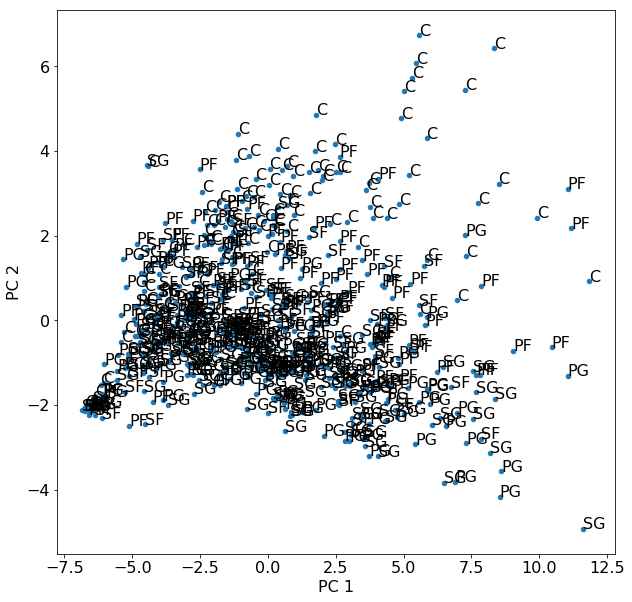

In [31]:
plot_transformed_data(pca,df_norm,figsize=(10,10))

## Pitfall #7: Too much data!

## Potential solution: Sparsen your data!

In [32]:
df = df[df['GS']>55] # Only consider players who have started at least 55 games
df.shape

(55, 25)

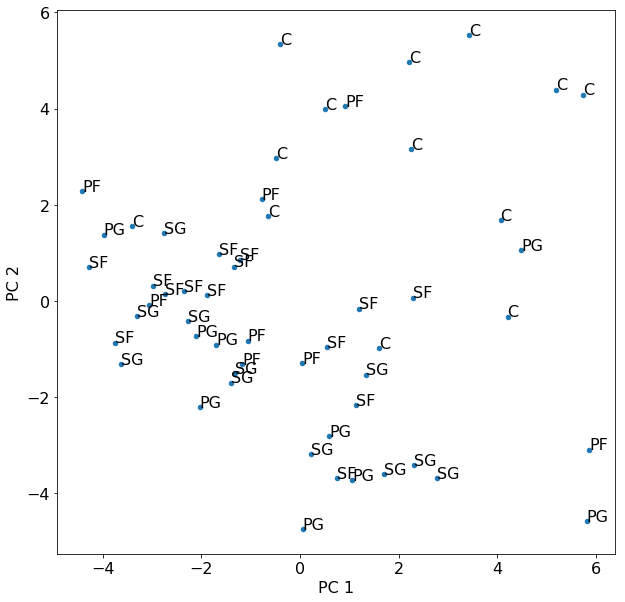

In [33]:
df_norm = normalize(df)
plot_transformed_data(pca,df_norm,figsize=(10,10))

In [34]:
df = pd.read_csv('data/basketball.csv')
df['Player'] = df['Player'].map(lambda x:x.split('\\')[0].split(' ')[1])
df = df.drop(['Pos','Rk','Tm','Age'],axis=1).set_index(['Player']).fillna(0)
df.head()

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
Player,,,,,,,,,,,,,,,,,,,,,
Abrines,56,8,16.0,1.6,4.1,0.384,1.1,3.0,0.367,0.5,...,0.872,0.4,1.3,1.7,0.4,0.5,0.1,0.4,1.7,4.9
Acy,54,8,20.7,1.8,5.3,0.336,1.4,4.2,0.329,0.4,...,0.821,0.7,3.5,4.1,0.8,0.5,0.4,1.0,2.1,5.8
Adams,57,57,32.6,6.0,9.5,0.631,0.0,0.0,0.000,6.0,...,0.571,5.1,3.9,9.1,1.0,1.2,1.1,1.5,2.9,14.0
Adebayo,51,11,20.5,2.7,4.8,0.551,0.0,0.1,0.000,2.7,...,0.732,1.6,3.8,5.4,1.6,0.5,0.6,0.9,2.1,7.4
Afflalo,45,2,12.8,1.2,3.0,0.388,0.5,1.3,0.386,0.7,...,0.833,0.1,1.3,1.4,0.6,0.0,0.2,0.4,1.1,3.2


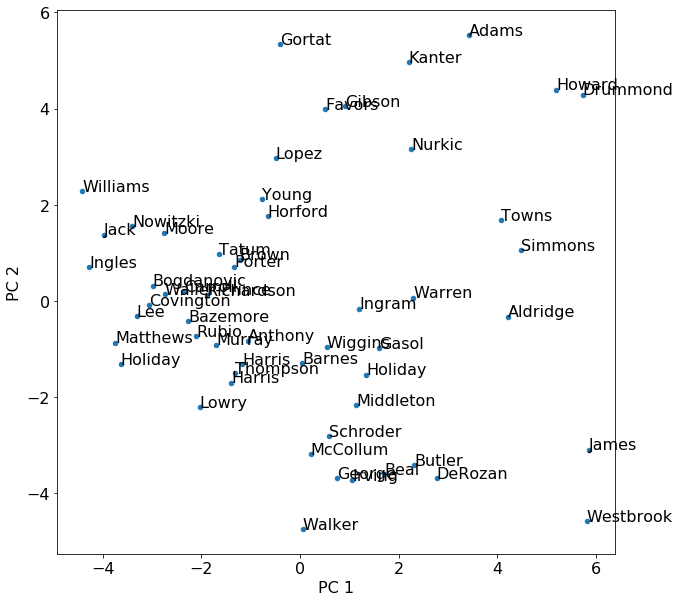

In [35]:
df = df[df['GS']>55] # Only consider players who have started at least 55 games
df_norm = normalize(df)
plot_transformed_data(pca,df_norm,figsize=(10,10))